Purpose of this notebook is to understand how to see the direction the player is facing relative to the goal.

Also to dissect the visualizer.py
- how does the direction work here and does it help understand
- can I make it work for kaggle11_vs_11
- can I improve the 3 vs 1 academy

In [89]:
from IPython.display import HTML
from kaggle_environments import make
import pandas as pd

## Visualizer

In [90]:
from matplotlib import animation, patches, rcParams
from matplotlib import pyplot as plt
from kaggle_environments.envs.football.helpers import *

WIDTH = 110
HEIGHT = 46.2
PADDING = 10


def initFigure(figwidth=12):
    figheight = figwidth * (HEIGHT + 2 * PADDING) / (WIDTH + 2 * PADDING)

    fig = plt.figure(figsize=(figwidth, figheight))
    ax = plt.axes(xlim=(-PADDING, WIDTH + PADDING), ylim=(-PADDING, HEIGHT + PADDING))
    plt.axis("off")
    return fig, ax


def drawPitch(ax):
    paint = "white"

    # Grass around pitch
    rect = patches.Rectangle((-PADDING / 2, -PADDING / 2), WIDTH + PADDING, HEIGHT + PADDING,
                             lw=1, ec="black", fc="#3f995b", capstyle="round")
    ax.add_patch(rect)

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), WIDTH, HEIGHT, ec=paint, fc="None", lw=2)
    ax.add_patch(rect)

    # Middle line
    plt.plot([WIDTH / 2, WIDTH / 2], [0, HEIGHT], color=paint, lw=2)

    # Dots
    dots_x = [11, WIDTH / 2, WIDTH - 11]
    for x in dots_x:
        plt.plot(x, HEIGHT / 2, "o", color=paint, lw=2)

    # Penalty box
    penalty_box_dim = [16.5, 40.3]
    penalty_box_pos_y = (HEIGHT - penalty_box_dim[1]) / 2

    rect = plt.Rectangle((0, penalty_box_pos_y),
                         penalty_box_dim[0], penalty_box_dim[1], ec=paint, fc="None", lw=2)
    ax.add_patch(rect)
    rect = plt.Rectangle((WIDTH, penalty_box_pos_y), -
                         penalty_box_dim[0], penalty_box_dim[1], ec=paint, fc="None", lw=2)
    ax.add_patch(rect)

    # Goal box
    goal_box_dim = [5.5, penalty_box_dim[1] - 11 * 2]
    goal_box_pos_y = (penalty_box_pos_y + 11)

    rect = plt.Rectangle((0, goal_box_pos_y),
                         goal_box_dim[0], goal_box_dim[1], ec=paint, fc="None", lw=2)
    ax.add_patch(rect)
    rect = plt.Rectangle((WIDTH, goal_box_pos_y),
                         -goal_box_dim[0], goal_box_dim[1], ec=paint, fc="None", lw=2)
    ax.add_patch(rect)

    # Goals
    goal_width = 0.044 / 0.42 * HEIGHT
    goal_pos_y = (HEIGHT / 2 - goal_width / 2)
    rect = plt.Rectangle((0, goal_pos_y), -2, goal_width,
                         ec=paint, fc=paint, lw=2, alpha=0.3)
    ax.add_patch(rect)
    rect = plt.Rectangle((WIDTH, goal_pos_y), 2, goal_width,
                         ec=paint, fc=paint, lw=2, alpha=0.3)
    ax.add_patch(rect)

    # Middle circle
    mid_circle = plt.Circle([WIDTH / 2, HEIGHT / 2], 9.15, color=paint, fc="None", lw=2)
    ax.add_artist(mid_circle)

    # Penalty box arcs
    left = patches.Arc([11, HEIGHT / 2], 2 * 9.15, 2 * 9.15,
                       color=paint, fc="None", lw=2, angle=0, theta1=308, theta2=52)
    ax.add_patch(left)
    right = patches.Arc([WIDTH - 11, HEIGHT / 2], 2 * 9.15, 2 * 9.15,
                        color=paint, fc="None", lw=2, angle=180, theta1=308, theta2=52)
    ax.add_patch(right)

    # Arcs on corners
    corners = [[0, 0], [WIDTH, 0], [WIDTH, HEIGHT], [0, HEIGHT]]
    angle = 0
    for x, y in corners:
        c = patches.Arc([x, y], 2, 2,
                        color=paint, fc="None", lw=2, angle=angle, theta1=0, theta2=90)
        ax.add_patch(c)
        angle += 90

In [80]:
`dd

In [91]:
steps = None
drawings = None
directions = None
ball = left_player = right_player = None
team_left = team_right = None
team_left_active = team_right_active = None
team_left_actions = team_right_actions = None
team_left_number = team_right_number = None
team_left_direction = team_right_direction = None
text_frame = game_mode = match_info = None

In [92]:


def init():
    ball.set_data([], [])
    left_player.set_data([], [])
    right_player.set_data([], [])
    team_left.set_data([], [])
    team_right.set_data([], [])
    team_left_active.set_data([], [])
    team_right_active.set_data([], [])
    return drawings


def animate(i):
    obs = extract_data(steps[i])

    # Draw info about ball possesion
    draw_active_players(obs, left_player, right_player)
    draw_team_active(obs, team_left_active, team_right_active)

    # Draw players
    draw_team(obs, team_left, "left_team")
    draw_team(obs, team_right, "right_team")

    draw_players_directions(obs, directions, "left_team")
    draw_players_directions(obs, directions, "right_team")

    draw_ball(obs, ball)

    # Draw textual informations
    text_frame.set_text(f"Step {i}/{obs['steps_left'] + i - 1}")
    game_mode.set_text(f"{obs['game_mode']} Mode")

    score_a, score_b = obs["score"]
    match_info.set_text(f"{score_a} : {score_b}")

    team_left_actions.set_text(player_actions(steps[i], 0))
    team_right_actions.set_text(player_actions(steps[i], 1))

    team_left_number.set_text(str(steps[i][0]["observation"]["players_raw"][0]["active"]))
    team_right_number.set_text(str(steps[i][1]["observation"]["players_raw"][0]["active"]))

    return drawings


def visualize(trace):
    global steps
    global drawings
    global directions
    global ball, left_player, right_player
    global team_left, team_right
    global team_left_active, team_right_active
    global text_frame, game_mode, match_info
    global team_left_actions, team_right_actions
    global team_left_number, team_right_number
    global team_left_direction, team_right_direction

    rcParams['font.family'] = 'monospace'
    rcParams['font.size'] = 12

    steps = trace

    fig, ax = initFigure()
    drawPitch(ax)
    ax.invert_yaxis()

    left_player, = ax.plot([], [], "o", ms=18, mfc="firebrick", mew=0, alpha=0.5)
    right_player, = ax.plot([], [], "o", ms=18, mfc="blue", mew=0, alpha=0.5)
    team_left, = ax.plot([], [], "o", ms=12, mfc="firebrick", mew=1, mec="white")
    team_right, = ax.plot([], [], "o", ms=12, mfc="blue", mew=1, mec="white")
    ball, = ax.plot([], [], "o", ms=8, mfc="wheat", mew=1, mec="black")

    team_left_active, = ax.plot([], [], "o", ms=16, mfc="mistyrose", mec="None")
    team_right_active, = ax.plot([], [], "o", ms=16, mfc="lightcyan", mec="None")

    textheight = -6
    text_frame = ax.text(-5, textheight, "", ha="left")
    match_info = ax.text(WIDTH / 2, textheight, "", ha="center", fontweight="bold")
    game_mode = ax.text(WIDTH + 5, textheight, "", ha="right")

    team_left_actions = ax.text(WIDTH / 4 + 2, textheight, "", ha="center")
    team_right_actions = ax.text(3 * WIDTH / 4 + 2, textheight, "", ha="center")

    team_left_number = ax.text(WIDTH / 2 - 7, -6.3, "", ha="center", fontsize=10)
    team_right_number = ax.text(WIDTH / 2 + 7, -6.3, "", ha="center", fontsize=10)

    # Drawing of directions definitely can be done in a better way
    directions = []
    for _ in range(22):
        direction, = ax.plot([], [], color="yellow", lw=1.5)
        directions.append(direction)

    drawings = [team_left_active, team_right_active, left_player, right_player,
                team_left, team_right, ball, text_frame, match_info,
                game_mode, team_left_actions, team_right_actions, team_left_number, team_right_number]

    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    anim = animation.FuncAnimation(fig, animate, init_func=init, blit=True,
                                   interval=100, frames=len(steps), repeat=False)
    return anim

In [95]:
def draw_players_directions(obs, directions, side):
    #print(len(obs))
    index = 0
    if "right" in side:
        index = 11
    for i, player_dir in enumerate(obs[f"{side}_direction"]):
        if i == 1:
            #print('player: {0}'.format(i))
            x_dir, y_dir = player_dir
            #print('x_dir: {0}, y_dir: {1}'.format(x_dir, y_dir))
            dist = (x_dir ** 2 + y_dir ** 2)**0.5 + 0.00001  # to prevent division by 0
            #print('dist: {0}'.format(dist))
            x = obs[side][i][0]
            y = obs[side][i][1]
            #print('x: {0} y: {1}'.format(x,y))
            directions[i + index].set_data([x, x + x_dir / dist], [y, y + y_dir / dist])
            #print('directions x_dir: {0}'.format((x, x + x_dir / dist)))
            #print('directions y_dir: {0}'.format((y, y + y_dir / dist)))

In [96]:
len(output)

26

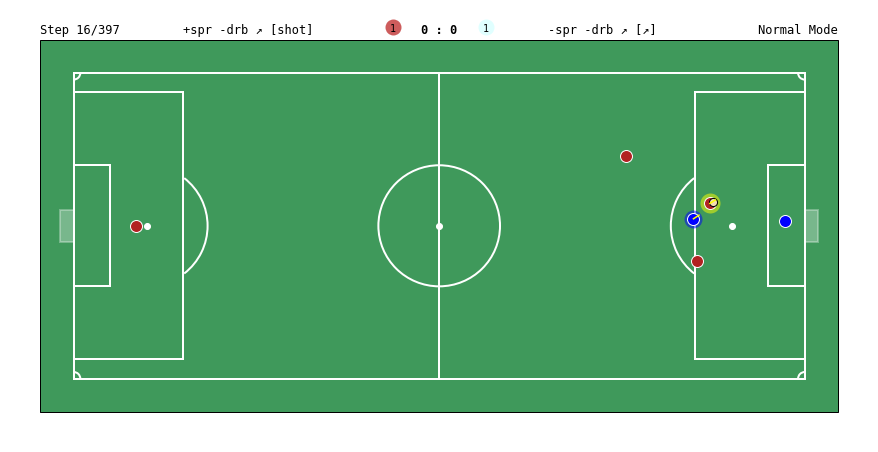

In [98]:
viz = visualize(output[3:20])
HTML(viz.to_html5_video())

## Run agents in scenario

In [94]:
scenario_num = 1
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": 'academy_3_vs_1_with_keeper', 
                          "running_in_notebook": True,
                          #"numSteps": 500
                         })

agent1 = "submit_agents/gfootball-with-memory-patterns/submission_v15.py"
agent2 = "submit_agents/best-open-rules-bot/submission_v2.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))

Staring a new environment c6aa7741-f320-488c-88ee-b63407112d61: with scenario: academy_3_vs_1_with_keeper
Resetting environment c6aa7741-f320-488c-88ee-b63407112d61: with scenario: academy_3_vs_1_with_keeper
Scores  0 : 0
Rewards 0 : 0


In [16]:
obs = extract_data(output[27])

In [17]:
obs

{'left_team': [(9.378918409347534, 23.098732950462),
  (98.45847874879837, 19.26832870990038),
  (96.54452830553055, 25.581304593384267),
  (77.48002052307129, 15.25825639665127)],
 'right_team': [(109.27965581417084, 22.005148012563588),
  (97.60220497846603, 20.080228014290334)],
 'ball': [99.47041392326355, 18.785368329286577, 0.1274760663509369],
 'score': [0, 0],
 'steps_left': 374,
 'ball_owned_team': 0,
 'left_player': (98.45847874879837, 19.26832870990038),
 'right_player': (97.60220497846603, 20.080228014290334),
 'right_team_roles': [0, 1],
 'left_team_roles': [0, 5, 5, 5],
 'left_team_direction': [[0.0, -0.0],
  [0.010598625987768173, -0.005435572005808353],
  [0.010044434107840061, -0.003906300291419029],
  [-0.008673177100718021, 0.007399417459964752]],
 'right_team_direction': [[0.001174562145024538, -0.0017198078567162156],
  [0.009440189227461815, -0.005200783722102642]],
 'game_mode': 'Normal'}

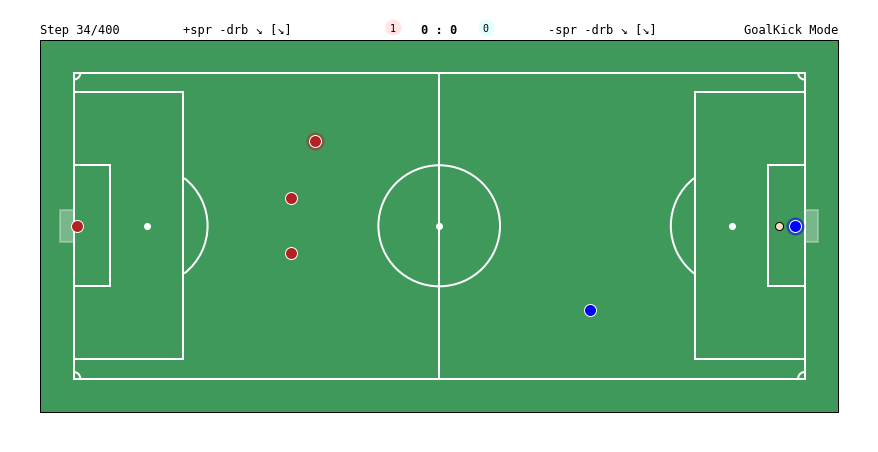

In [15]:
viz = visualize(output)
HTML(viz.to_html5_video())